In [131]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# import hcp_utils as hcp
# import nibabel as nib
from nilearn import plotting,image,datasets
import pandas as pd
%matplotlib inline
niimg = datasets.load_mni152_template()
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import matplotlib.image as mpimg
import networkx as nx
import h5py as h5

In [132]:
#schaefer 116 coordinates
subcortical_coords = np.loadtxt('../data/external/Tian_Subcortex_S1_3T_COG.txt')
Schaefer100 = pd.read_csv('../data/external/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
cortical_coords = np.array(Schaefer100[['R','A','S']])
SchaeferTian116_coords = np.concatenate((np.array(subcortical_coords),cortical_coords),axis=0)

networks_names = ['Subcortical','Visual','Somatomotor','Dorsal attention','Salience ventral attention','Limbic','Control','Default mode']
networks_colors = ['black','red','blue','green','purple','orange','brown','pink']
networks_order = [0,1,2,3,4,5,6,7,1,2,3,4,5,6,7]
networks_number_of_rois_hemisphere = [16,9,6,8,7,3,4,13,
                           8,8,7,5,2,9,11]
networks_number_of_rois2 = [16,17,14,15,12,5,13,24]

network_indices = [] # indicates indices from the Schaefer 116 atlas into a label where networks are put together
network_indices2 = [] #indicates the indices in each network after relabeling
network_indices3 = [] #indicates the yeo network each area belongs to

start1 = 0
start2 = 66
start3 = 0
#reorder such that the first left and right hemisphere are ordered together
for network in range(8):
    if network==0:
        tmp = np.concatenate((np.arange(start1,start1+networks_number_of_rois_hemisphere[network],step=2),
                                np.arange(start1+1,start1+networks_number_of_rois_hemisphere[network],step=2)))
        network_indices.append(tmp)
        start1 += networks_number_of_rois_hemisphere[network]
    else:
        network_index = np.where(np.array(networks_order)==network)[0]
        tmp = np.concatenate((np.arange(start1,start1+networks_number_of_rois_hemisphere[network_index[0]]),
                             np.arange(start2,start2+networks_number_of_rois_hemisphere[network_index[1]])))
        network_indices.append(tmp)
        start1 += networks_number_of_rois_hemisphere[network_index[0]]
        start2 += networks_number_of_rois_hemisphere[network_index[1]]
    network_indices2.append(np.arange(start3,start3+networks_number_of_rois2[network]))
    network_indices3.append(np.ones(networks_number_of_rois2[network])*network)
    start3 += networks_number_of_rois2[network]
network_indices_concat = np.concatenate(network_indices)
network_indices3 = np.concatenate(network_indices3).astype(int)

In [133]:
with open('../data/external/Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S1_label.txt', 'r') as f:
    lines = f.readlines()
lines = lines[0::2]
#in each string, remove the newline character
lines = [line.strip() for line in lines]
#check correct ordering of networks
lines_new_order = np.array(lines)[network_indices_concat]

In [134]:
angles = np.array([0, 0.25, 0.5, 0.75, 1.0])  # Normalized positions of -pi to pi
colors = ['blue', 'green', 'red', 'yellow', 'blue']  # Color for each angle

# Create a custom colormap
cyclic_cmap = LinearSegmentedColormap.from_list('cyclic_map', list(zip(angles, colors)))

In [135]:
# make another colormap that is the second half of 'bwr'
bwr2 = plt.cm.bwr
colors_bwr2 = bwr2(np.linspace(0, 1, 256))
colors_bwr2 = colors_bwr2[128:]
cmap_bwr2 = LinearSegmentedColormap.from_list('bwr2', colors_bwr2)

In [136]:
def plot_matrix(matrix, title, cmap='bwr',clim=(-0.5,0.5)):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), gridspec_kw={'height_ratios': [10, 1], 'width_ratios': [1,10], 'wspace':-0.05, 'hspace':-0.15})
    plotting.plot_matrix(matrix, cmap=cmap, colorbar=False, axes=ax[0,1],vmin=clim[0],vmax=clim[1])
    # divider = make_axes_locatable(ax[0,1])
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # plt.colorbar(ax[0,1].get_images()[0], cax=cax, orientation='vertical')
    # if cmap=='bwr':
    #     cax.set_yticks([clim[0],0,clim[1]])
    #     cax.set_yticklabels([str(clim[0]),0,str(clim[1])],fontsize=15)
    # elif clim[0]==0:
    #     cax.set_yticks([clim[0],clim[1]])
    #     cax.set_yticklabels([str(clim[0]),str(clim[1])],fontsize=15)
    # else:
    #     cax.set_yticks([clim[0],0,clim[1]])
    #     cax.set_yticklabels([r'$-\pi$   ',0,r'$\pi$   '],fontsize=15)
    ax[0,1].set_xticks([])
    ax[0,1].set_yticks([])
    # ax[0,1].set_title(title, fontsize=20)
    ax[1,0].axis('off')
    ax[1,1].axis('off')
    ax[0,0].axis('off')
    
    # Create a 1D array that represents the colored boxes
    color_boxes = np.zeros((1, matrix.shape[0], 3))

    # Assign colors to the corresponding segments
    for i, color in enumerate(networks_colors):
        start = sum(networks_number_of_rois2[:i])
        end = start + networks_number_of_rois2[i]
        #use the predefined colors
        color_boxes[0, start:end, :] = plt.cm.colors.to_rgb(color)

    # Plot the color boxes below the matrix
    ax[0,0].imshow(np.swapaxes(color_boxes,0,1), aspect='auto')
    new_ax00_position = [ax[0,0].get_position().x0, ax[0,1].get_position().y0, ax[0,0].get_position().width*0.5, ax[0,1].get_position().height]
    ax[0,0].set_position(new_ax00_position)

    ax[1,1].imshow(color_boxes, aspect='auto')
    new_ax11_position = [ax[1,1].get_position().x0, ax[1,1].get_position().y0-0.025, ax[0,1].get_position().width, ax[1,1].get_position().height*0.5]
    ax[1,1].set_position(new_ax11_position)
    fig.savefig('figs/'+title+'.png',dpi=300,bbox_inches='tight')
    plt.close()
    return

def avg_matrix_in_networks(matrix, network_indices):
    avg_matrix = np.zeros((len(network_indices), len(network_indices)),dtype=matrix.dtype)
    for i, network1 in enumerate(network_indices):
        for j, network2 in enumerate(network_indices):
            avg_matrix[i, j] = np.mean(matrix[network1, :][:, network2])
    return avg_matrix

def get_Z(params,idx,sort=True,model='Watson'):
    if model in ['Watson','Complex_Watson']:
        Z = np.outer(params['mu'][:,idx],params['mu'][:,idx].conj())*np.sqrt(params['kappa'][idx])
    elif model in ['ACG','Complex_ACG','MACG']:
        M = params['M'][idx]
        o = np.linalg.norm(M,'fro')**2
        gamma = 1/(1+o/116)
        Z = gamma*(M@M.conj().T+np.eye(116))
    elif model in ['SingularWishart']:
        M = params['M'][idx]
        gamma = params['gamma'][idx]
        Z = M@M.T+gamma*np.eye(116)
    else:
        raise ValueError('Model not recognized')
    if sort:
        Z = Z[network_indices_concat,:][:,network_indices_concat]
    return Z

## Global coherence network

In [137]:
data_file = '../data/processed/fMRI_SchaeferTian116_complex.h5'
num_subs = 100
with h5.File(data_file,'r') as f:
    data_train = f['U_train'][:][:1200*num_subs]
Z_global_coh = np.mean(data_train@np.swapaxes(data_train.conj(),-2,-1),axis=0)*100
Z_global_coh = Z_global_coh[network_indices_concat,:][:,network_indices_concat]

# c = 0.005
c = 0.5
plot_matrix(np.real(Z_global_coh), 'Global phase coherence, real',clim=(-c,c))
plot_matrix(np.imag(Z_global_coh), 'Global phase coherence, imaginary',clim=(-c,c))
plot_matrix(np.abs(Z_global_coh), 'Global phase coherence, magnitude',clim=(0,c),cmap=cmap_bwr2)
plot_matrix(np.angle(Z_global_coh), 'Global phase coherence, angle',clim=(-np.pi,np.pi),cmap=cyclic_cmap)

In [138]:
data_file = '../data/processed/fMRI_SchaeferTian116_GSR_complex.h5'
num_subs = 100
with h5.File(data_file,'r') as f:
    data_train = f['U_train'][:][:1200*num_subs]
Z_global_coh_GSR = np.mean(data_train@np.swapaxes(data_train.conj(),-2,-1),axis=0)*100
Z_global_coh_GSR = Z_global_coh_GSR[network_indices_concat,:][:,network_indices_concat]

# c = 0.005
c = 0.5
plot_matrix(np.real(Z_global_coh_GSR), 'Global phase coherence, GSR, real',clim=(-c,c))
plot_matrix(np.imag(Z_global_coh_GSR), 'Global phase coherence, GSR, imaginary',clim=(-c,c))
plot_matrix(np.abs(Z_global_coh_GSR), 'Global phase coherence, GSR, magnitude',clim=(0,c),cmap=cmap_bwr2)
plot_matrix(np.angle(Z_global_coh_GSR), 'Global phase coherence, GSR, angle',clim=(-np.pi,np.pi),cmap=cyclic_cmap)

## K1 solutions

In [139]:
#K1 Watson
clim = (-0.5,0.5)
clim2 = (0,0.5)
print('Watson')
params = np.load('../data/results/116_results/params/Watson_rank1_K1_params.npy', allow_pickle=True).item()
Z = get_Z(params,idx=0,model='Watson')
plot_matrix(Z, 'Watson K=1',clim=clim)

#K1 ACG rank 10
print('ACG rank 10')
params = np.load('../data/results/116_results/params/ACG_rank9_K1_params.npy', allow_pickle=True).item()
Z = get_Z(params,idx=0,model='ACG')
plot_matrix(Z, 'ACG rank 10 K=1',clim=clim)

#K1 ACG rank 25
print('ACG rank 25')
params = np.load('../data/results/116_results/params/ACG_rank25_K1_params.npy', allow_pickle=True).item()
Z = get_Z(params,idx=0,model='ACG')
plot_matrix(Z, 'ACG rank 25 K=1',clim=clim)

#K1 MACG rank 10
print('MACG rank 10')
params = np.load('../data/results/116_results/params/MACG_rank9_K1_params.npy', allow_pickle=True).item()
Z = get_Z(params,idx=0,model='MACG')
plot_matrix(Z, 'MACG rank 10 K=1',clim=clim)

#K1 MACG rank 25
print('MACG rank 25')
params = np.load('../data/results/116_results/params/MACG_rank25_K1_params.npy', allow_pickle=True).item()
Z = get_Z(params,idx=0,model='MACG')
plot_matrix(Z, 'MACG rank 25 K=1',clim=clim)

#K1 Singular Wishart rank 10
print('Singular Wishart rank 10')
params = np.load('../data/results/116_results/params/SingularWishart_rank9_K1_params.npy', allow_pickle=True).item()
Z = get_Z(params,idx=0,model='SingularWishart')
plot_matrix(Z, 'Singular Wishart rank 10 K=1',clim=clim)

#K1 Singular Wishart rank 25
print('Singular Wishart rank 25')
params = np.load('../data/results/116_results/params/SingularWishart_rank25_K1_params.npy', allow_pickle=True).item()
Z = get_Z(params,idx=0,model='SingularWishart')
plot_matrix(Z, 'Singular Wishart rank 25 K=1',clim=clim)

#K1 complex Watson 
print('Complex Watson')
params = np.load('../data/results/116_results/params/Complex_Watson_rank1_K1_params.npy', allow_pickle=True).item()
Z = get_Z(params,idx=0,model='Complex_Watson')
plot_matrix(np.real(Z), 'Complex Watson K=1, real',clim=clim)
plot_matrix(np.imag(Z), 'Complex Watson K=1, imaginary',clim=clim)
plot_matrix(np.abs(Z), 'Complex Watson K=1, magnitude',clim=clim2,cmap=cmap_bwr2)
plot_matrix(np.angle(Z), 'Complex Watson K=1, angle',clim=(-np.pi,np.pi),cmap=cyclic_cmap)

#K1 complex ACG rank 10
print('Complex ACG rank 10')
params = np.load('../data/results/116_results/params/Complex_ACG_rank9_K1_params.npy', allow_pickle=True).item()
Z = get_Z(params,idx=0,model='Complex_ACG')
plot_matrix(np.real(Z), 'Complex ACG rank 10, real',clim=clim)
plot_matrix(np.imag(Z), 'Complex ACG rank 10, imaginary',clim=clim)
plot_matrix(np.abs(Z), 'Complex ACG rank 10, magnitude',clim=clim2,cmap=cmap_bwr2)
plot_matrix(np.angle(Z), 'Complex ACG rank 10, angle',clim=(-np.pi,np.pi),cmap=cyclic_cmap)

#K1 complex ACG rank 25
print('Complex ACG rank 25')
params = np.load('../data/results/116_results/params/Complex_ACG_rank25_K1_params.npy', allow_pickle=True).item()
Z = get_Z(params,idx=0,model='Complex_ACG')
plot_matrix(np.real(Z), 'Complex ACG rank 25, real',clim=clim)
plot_matrix(np.imag(Z), 'Complex ACG rank 25, imaginary',clim=clim)
plot_matrix(np.abs(Z), 'Complex ACG rank 25, magnitude',clim=clim2,cmap=cmap_bwr2)
plot_matrix(np.angle(Z), 'Complex ACG rank 25, angle',clim=(-np.pi,np.pi),cmap=cyclic_cmap)

Watson
ACG rank 10
ACG rank 25
MACG rank 10
MACG rank 25
Singular Wishart rank 10


FileNotFoundError: [Errno 2] No such file or directory: '../data/results/116_results/params/SingularWishart_rank9_K1_params.npy'

(-0.5, 1919.5, 1926.5, -0.5)

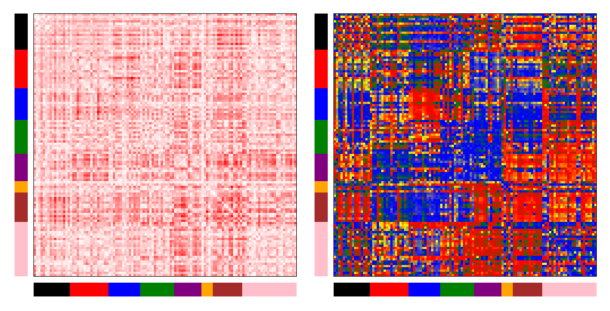

In [146]:
params = np.load('../data/results/116_results/params/modelorder_realdata_Complex_ACG_K=2_rank=25_inner6.npy', allow_pickle=True).item()
Z1 = get_Z(params,idx=0,model='Complex_ACG')
Z2 = get_Z(params,idx=1,model='Complex_ACG')
plot_matrix(np.abs(Z1-Z2), 'Complex ACG rank 25, magnitude, difference_K=2',clim=clim2,cmap=cmap_bwr2)
plot_matrix(np.angle(Z1-Z2), 'Complex ACG rank 25, angle, difference_K=2',clim=(-np.pi,np.pi),cmap=cyclic_cmap)

fig = plt.figure(figsize=(6,3),constrained_layout=True)
gs = fig.add_gridspec(1,2)
ax00 = fig.add_subplot(gs[0])
ax00.imshow(mpimg.imread('figs/Complex ACG rank 25, magnitude, difference_K=2.png'))
ax00.axis('off')

ax10 = fig.add_subplot(gs[1])
ax10.imshow(mpimg.imread('figs/Complex ACG rank 25, angle, difference_K=2.png'))
ax10.axis('off')

## main paper fig

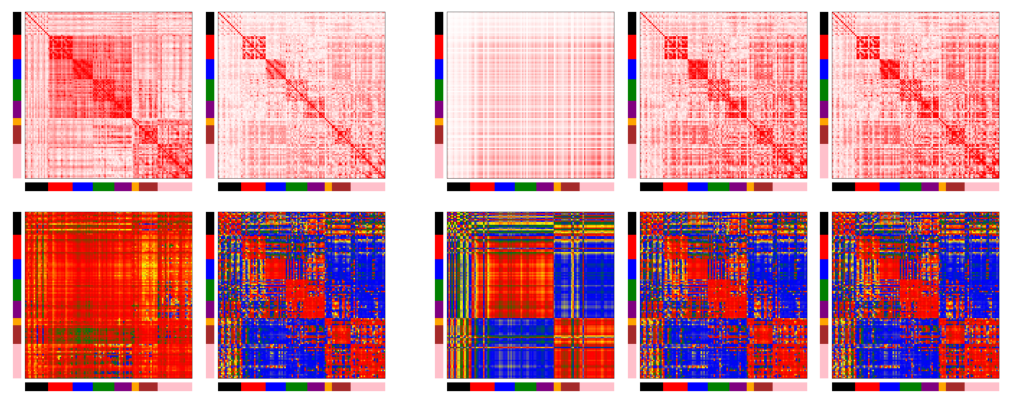

In [140]:
fig = plt.figure(figsize=(10,4),constrained_layout=True)
gs = fig.add_gridspec(2,6,width_ratios=[1,1,0.2,1,1,1],hspace=0)
ax00 = fig.add_subplot(gs[0,0])
ax00.imshow(mpimg.imread('figs/Global phase coherence, magnitude.png'))
ax00.axis('off')

ax10 = fig.add_subplot(gs[1,0])
ax10.imshow(mpimg.imread('figs/Global phase coherence, angle.png'))
ax10.axis('off')

ax01 = fig.add_subplot(gs[0,1])
ax01.imshow(mpimg.imread('figs/Global phase coherence, GSR, magnitude.png'))
ax01.axis('off')

ax11 = fig.add_subplot(gs[1,1])
ax11.imshow(mpimg.imread('figs/Global phase coherence, GSR, angle.png'))
ax11.axis('off')

ax30 = fig.add_subplot(gs[0,3])
ax30.imshow(mpimg.imread('figs/Complex Watson K=1, magnitude.png'))
ax30.axis('off')

ax31 = fig.add_subplot(gs[1,3])
ax31.imshow(mpimg.imread('figs/Complex Watson K=1, angle.png'))
ax31.axis('off')

ax40 = fig.add_subplot(gs[0,4])
ax40.imshow(mpimg.imread('figs/Complex ACG rank 10, magnitude.png'))
ax40.axis('off')

ax41 = fig.add_subplot(gs[1,4])
ax41.imshow(mpimg.imread('figs/Complex ACG rank 10, angle.png'))
ax41.axis('off')

ax50 = fig.add_subplot(gs[0,5])
ax50.imshow(mpimg.imread('figs/Complex ACG rank 25, magnitude.png'))
ax50.axis('off')

ax51 = fig.add_subplot(gs[1,5]) 
ax51.imshow(mpimg.imread('figs/Complex ACG rank 25, angle.png'))
ax51.axis('off')

fig.savefig('figs/Global_phase_coherence.png',dpi=300,bbox_inches='tight')

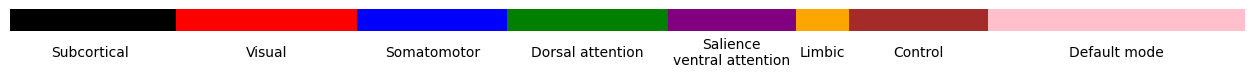

In [ ]:
#let the first subplot show the 8 colored boxes vertically with the network names next to them
networks_names2 = ['Subcortical','Visual','Somatomotor','Dorsal attention','Salience\nventral attention','Limbic','Control','Default mode']
fig,ax = plt.subplots(1,1,figsize=(16,1))
color_boxes = np.zeros((116, 2, 3))
for i, color in enumerate(networks_colors):
    start = sum(networks_number_of_rois2[:i])
    end = start + networks_number_of_rois2[i]
    color_boxes[start:end,:, :] = plt.cm.colors.to_rgb(color)
ax.imshow(np.swapaxes(color_boxes,0,1), aspect='equal')
ax.set_xlim(0,116)
ax.axis('off')
for i in range(8):
    ax.text((sum(networks_number_of_rois2[:i])+networks_number_of_rois2[i]/2-0.5),3.5, networks_names2[i], ha='center', va='center',fontsize=10)
fig.savefig('figs/Networks_labels.png',dpi=300,bbox_inches='tight')

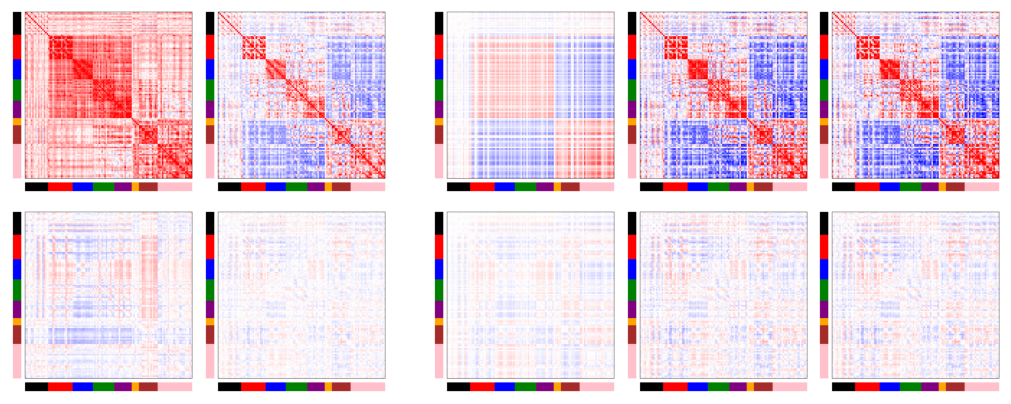

In [ ]:
fig = plt.figure(figsize=(10,4),constrained_layout=True)
gs = fig.add_gridspec(2,6,width_ratios=[1,1,0.2,1,1,1],hspace=0)
ax00 = fig.add_subplot(gs[0,0])
ax00.imshow(mpimg.imread('figs/Global phase coherence, real.png'))
ax00.axis('off')

ax10 = fig.add_subplot(gs[1,0])
ax10.imshow(mpimg.imread('figs/Global phase coherence, imaginary.png'))
ax10.axis('off')

ax01 = fig.add_subplot(gs[0,1])
ax01.imshow(mpimg.imread('figs/Global phase coherence, GSR, real.png'))
ax01.axis('off')

ax11 = fig.add_subplot(gs[1,1])
ax11.imshow(mpimg.imread('figs/Global phase coherence, GSR, imaginary.png'))
ax11.axis('off')

ax30 = fig.add_subplot(gs[0,3])
ax30.imshow(mpimg.imread('figs/Complex Watson K=1, real.png'))
ax30.axis('off')

ax31 = fig.add_subplot(gs[1,3])
ax31.imshow(mpimg.imread('figs/Complex Watson K=1, imaginary.png'))
ax31.axis('off')

ax40 = fig.add_subplot(gs[0,4])
ax40.imshow(mpimg.imread('figs/Complex ACG rank 10, real.png'))
ax40.axis('off')

ax41 = fig.add_subplot(gs[1,4])
ax41.imshow(mpimg.imread('figs/Complex ACG rank 10, imaginary.png'))
ax41.axis('off')

ax50 = fig.add_subplot(gs[0,5])
ax50.imshow(mpimg.imread('figs/Complex ACG rank 25, real.png'))
ax50.axis('off')

ax51 = fig.add_subplot(gs[1,5]) 
ax51.imshow(mpimg.imread('figs/Complex ACG rank 25, imaginary.png'))
ax51.axis('off')

fig.savefig('figs/Global_phase_coherence_realimag.png',dpi=300,bbox_inches='tight')

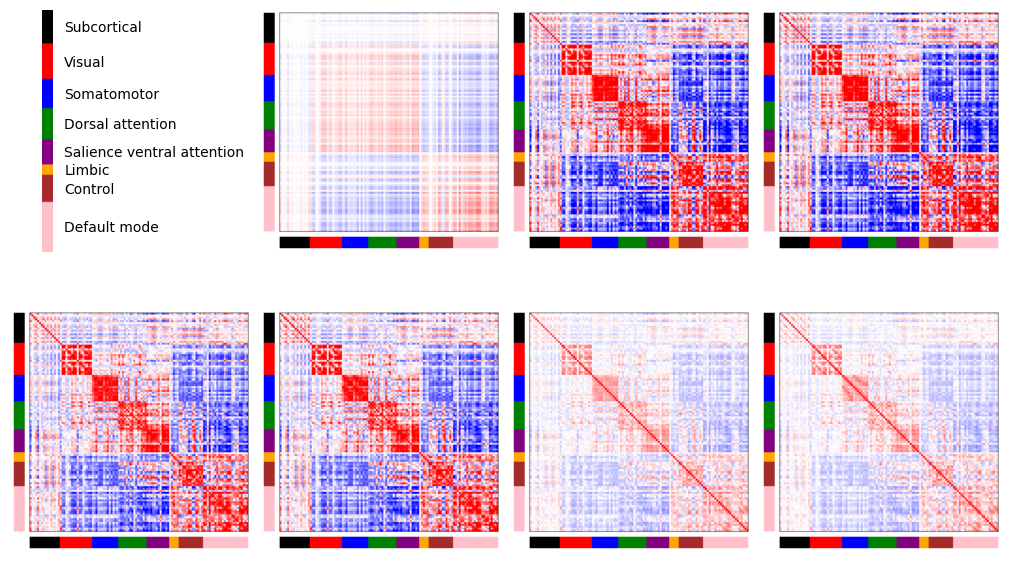

In [ ]:
fig,axs = plt.subplots(2,4,figsize=(10,6),layout='constrained')

#let the first subplot show the 8 colored boxes vertically with the network names next to them
color_boxes = np.zeros((5, 116, 3))
for i, color in enumerate(networks_colors):
    start = sum(networks_number_of_rois2[:i])
    end = start + networks_number_of_rois2[i]
    color_boxes[:, start:end, :] = plt.cm.colors.to_rgb(color)
axs[0,0].imshow(np.swapaxes(color_boxes,0,1), aspect='equal')
axs[0,0].set_xlim(-16,100)
axs[0,0].axis('off')
for i in range(8):
    axs[0,0].text(10, (sum(networks_number_of_rois2[:i])+sum(networks_number_of_rois2[:i+1]))/2, networks_names[i], ha='left', va='center',fontsize=10)

img = mpimg.imread('figs/Watson K=1.png')
axs[0,1].imshow(img)
axs[0,1].axis('off')

img = mpimg.imread('figs/ACG rank 10 K=1.png')
axs[0,2].imshow(img)
axs[0,2].axis('off')

img = mpimg.imread('figs/ACG rank 25 K=1.png')
axs[0,3].imshow(img)
axs[0,3].axis('off')

img = mpimg.imread('figs/MACG rank 10 K=1.png')
axs[1,0].imshow(img)
axs[1,0].axis('off')

img = mpimg.imread('figs/MACG rank 25 K=1.png')
axs[1,1].imshow(img)
axs[1,1].axis('off')

img = mpimg.imread('figs/Singular Wishart rank 10 K=1.png')
axs[1,2].imshow(img)
axs[1,2].axis('off')

img = mpimg.imread('figs/Singular Wishart rank 25 K=1.png')
axs[1,3].imshow(img)
axs[1,3].axis('off')

fig.savefig('figs/116_results_K1_realmodels.png',dpi=300)

In [ ]:
def plot_graph_yeo(color_matrix,linewidth_matrix):

    include_self_loop = 0 #0 means yes, 1 means no

    #make one networkx graph encoding both color and linewidth
    num_nodes = color_matrix.shape[0]
    if num_nodes == 8:
        linewidth_weight = 10
    else:
        linewidth_weight = 0.1
    # G_color = nx.from_numpy_array(color_matrix)
    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i)
    for i in range(num_nodes):
        for j in range(i+include_self_loop,num_nodes):
            weight = np.cos(color_matrix[i,j])
            # weight = (np.cos(color_matrix[i,j])+1)/2
            G.add_edge(i,j,weight=weight)
    # G_color[:][:]['color'] = color_matrix
    edge_weights = []
    for i in range(num_nodes):
        for j in range(i+include_self_loop,num_nodes):
            edge_weights.append(linewidth_matrix[i,j]*linewidth_weight)
    edge_colors = []
    for i in range(num_nodes):
        for j in range(i+include_self_loop,num_nodes):
            #map color_matrix[i,j] to a color in the cyclic colormap
            col = cyclic_cmap(((color_matrix[i,j]+np.pi)/(2*np.pi)*256).astype(int))
            edge_colors.append(col)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axis('off')
    pos = nx.circular_layout(G)
    if num_nodes==8:
        pos2 = {}
        pos2[0] = pos[2]
        pos2[1] = pos[3]
        pos2[2] = pos[4]
        pos2[3] = pos[5]
        pos2[4] = pos[6]
        pos2[5] = pos[7]
        pos2[6] = pos[0]
        pos2[7] = pos[1]
        pos = pos2

    nx.draw_networkx_edges(G,pos=pos,ax=ax,width=edge_weights*1000,edge_color=edge_colors)#edge_cmap=cyclic_cmap#,edge_vmin=-np.pi,edge_vmax=np.pi
    # nx.draw_networkx_edges(G,pos=pos,ax=ax,width=edge_weights*1000,edge_vmin=-np.pi,edge_vmax=np.pi,edge_color=edge_colors)#edge_cmap=cyclic_cmap
    
    if num_nodes==8:
        node_size = 200
        node_colors = networks_colors
        ydist = 0.1
        xdist = 0.18
        fontsize = 12
        # nx.draw_networkx_labels(G,pos=pos,labels=labels,ax=ax,font_weight='bold',horizontalalignment='center',verticalalignment='bottom',font_size=14,clip_on=False)
        ax.text(pos[0][0], pos[0][1]+ydist*2.5, networks_names[0], ha='center', va='center',fontsize=fontsize)
        ax.text(pos[1][0]-xdist*1.1, pos[1][1]+0, networks_names[1], ha='center', va='center',fontsize=fontsize)
        ax.text(pos[2][0]-xdist*2.1, pos[2][1]-0, networks_names[2], ha='center', va='center',fontsize=fontsize)
        ax.text(pos[3][0]-xdist*2.4, pos[3][1]-0, networks_names[3], ha='center', va='center',fontsize=fontsize)
        ax.text(pos[4][0], pos[4][1]-ydist, networks_names[4], ha='center', va='center',fontsize=fontsize)
        ax.text(pos[5][0]+xdist*1.2, pos[5][1]-0, networks_names[5], ha='center', va='center',fontsize=fontsize)
        ax.text(pos[6][0]+xdist*1.4, pos[6][1]-0, networks_names[6], ha='center', va='center',fontsize=fontsize)
        ax.text(pos[7][0]+xdist*2.1, pos[7][1]+0, networks_names[7], ha='center', va='center',fontsize=fontsize)
    else:
        node_size = 50
        node_colors = []
        for i in range(num_nodes):
            node_colors.append(networks_colors[network_indices3[i]])
    nx.draw_networkx_nodes(G,pos=pos,ax=ax,node_color=node_colors,node_size=node_size,alpha=1)  
    return fig

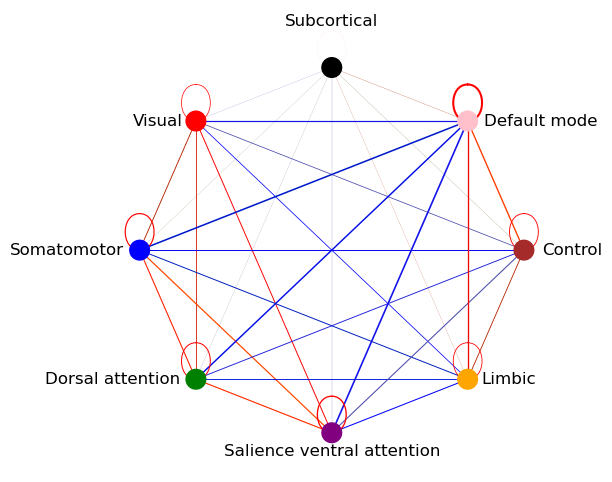

In [ ]:
params = np.load('../data/results/116_results/params/Complex_Watson_rank1_K1_params.npy', allow_pickle=True).item()
Z = get_Z(params,idx=0,sort=False,model='Complex_Watson')
Z_yeo = avg_matrix_in_networks(Z, network_indices)
fig=plot_graph_yeo(np.angle(Z_yeo),np.abs(Z_yeo))

In [ ]:
np.min(np.abs(Z))

0.00040056090104799875

[0.09363518 0.09797453 0.08996008 0.10539706 0.098882   0.0936555
 0.10056337 0.09473288 0.11713753 0.10806188]


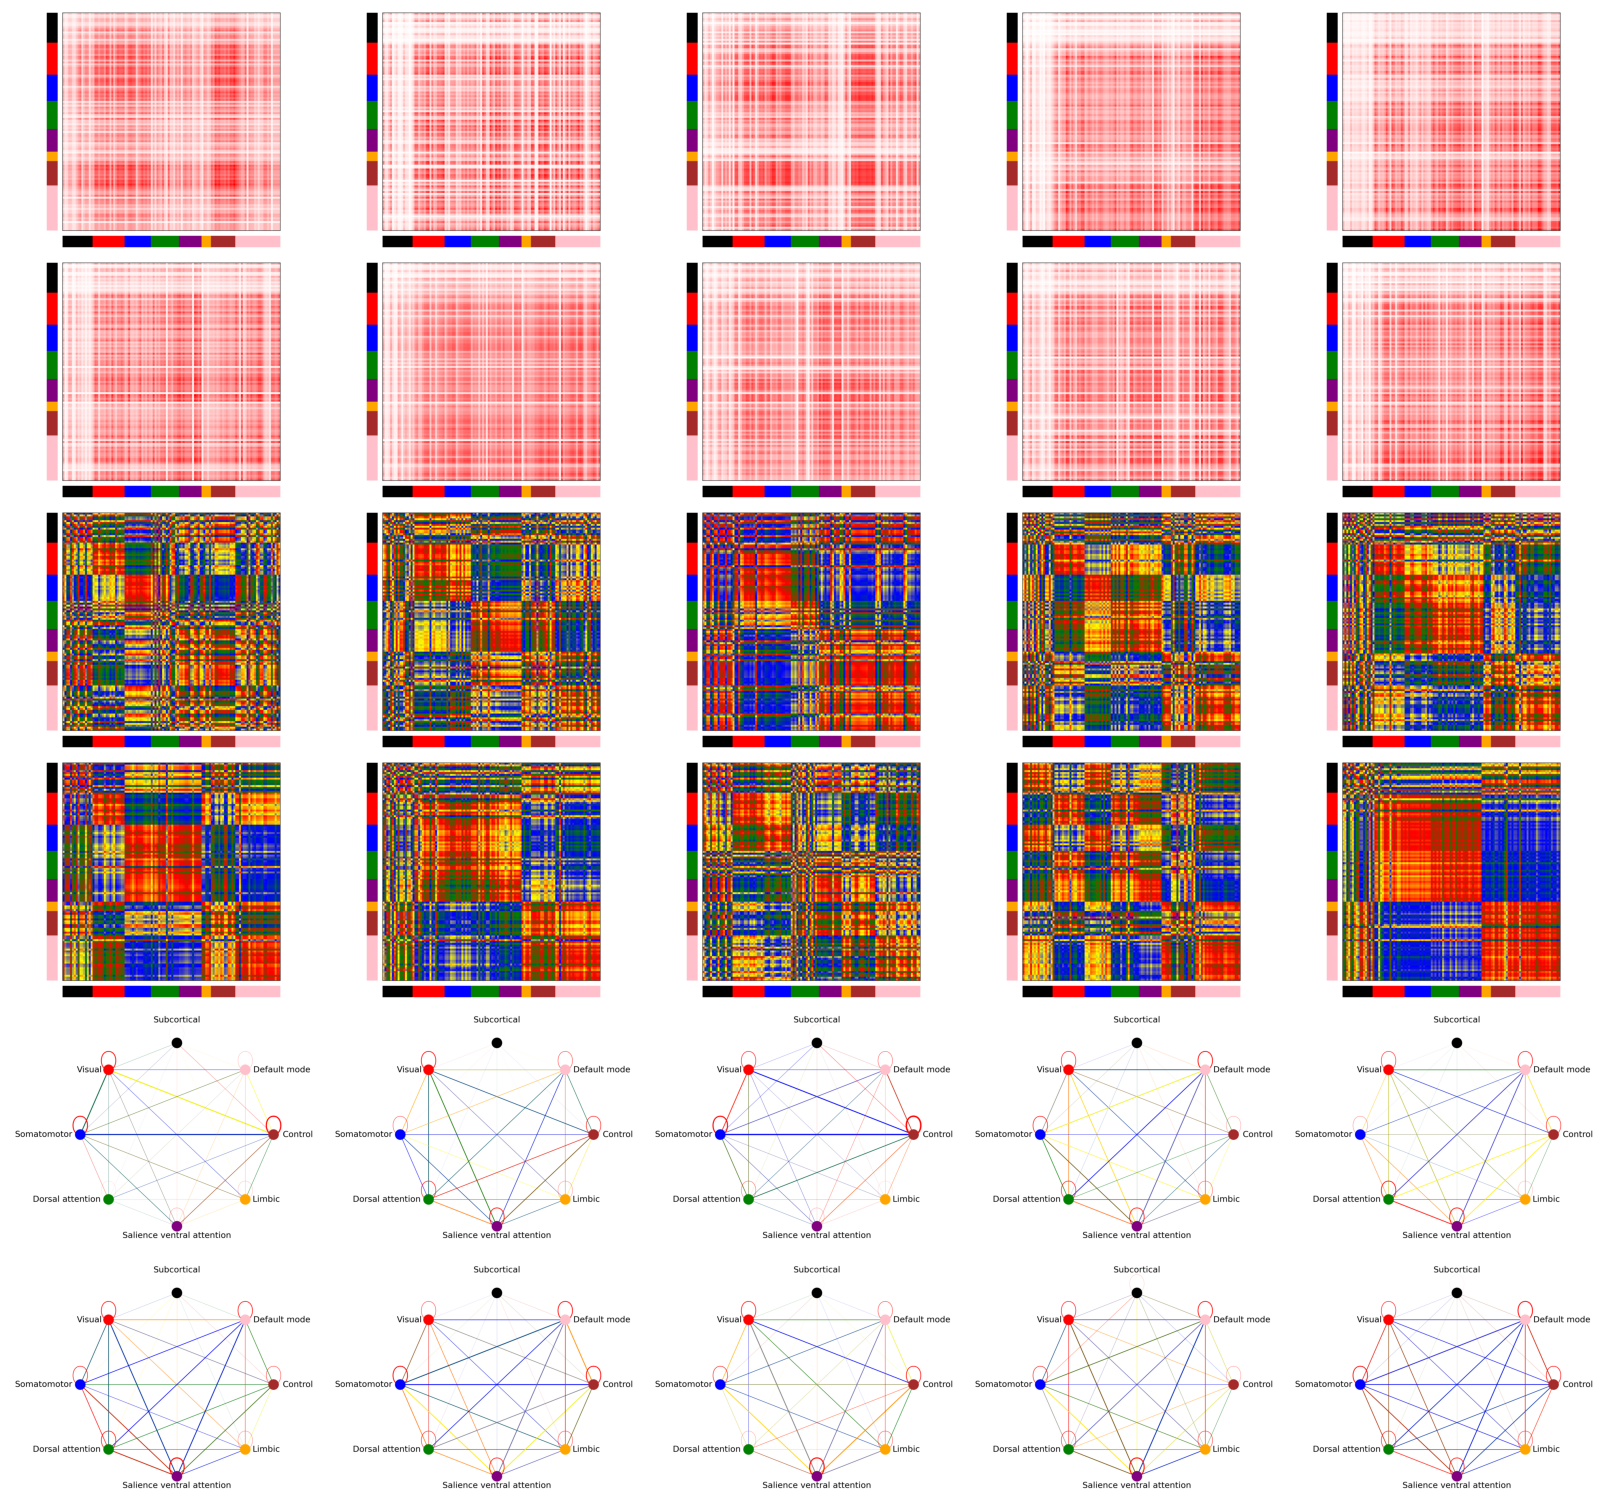

In [ ]:
params = np.load('../data/results/116_results/params/modelorder_realdata_Complex_Watson_K=10_rank=10_inner0.npy', allow_pickle=True).item()
for k in range(10):
    Z= get_Z(params,idx=k,sort=True,model='Complex_Watson')
    plot_matrix(np.abs(Z), 'Complex Watson K=10, magnitude'+str(k),clim=(0,0.3),cmap=cmap_bwr2)
    plot_matrix(np.angle(Z), 'Complex Watson K=10, angle'+str(k),clim=(-np.pi,np.pi),cmap=cyclic_cmap)

fig1 = plt.figure(figsize=(16,15),constrained_layout=True)
for k in range(10):
    img = mpimg.imread('figs/Complex Watson K=10, magnitude'+str(k)+'.png')
    ax = fig1.add_subplot(6,5,k+1)
    ax.imshow(img)
    ax.axis('off')
    img = mpimg.imread('figs/Complex Watson K=10, angle'+str(k)+'.png')
    ax = fig1.add_subplot(6,5,k+11)
    ax.imshow(img)
    ax.axis('off')
    Z = get_Z(params,idx=k,sort=False,model='Complex_Watson')
    Z_yeo = avg_matrix_in_networks(Z, network_indices)
    fig=plot_graph_yeo(np.angle(Z_yeo),np.abs(Z_yeo))
    fig.savefig('figs/Complex_Watson_rank1_K10_'+str(k)+'.png',dpi=300,bbox_inches='tight')
    plt.close()
    img = mpimg.imread('figs/Complex_Watson_rank1_K10_'+str(k)+'.png')
    ax = fig1.add_subplot(6,5,k+1+20)
    ax.imshow(img)
    ax.axis('off')
print(params['pi'])

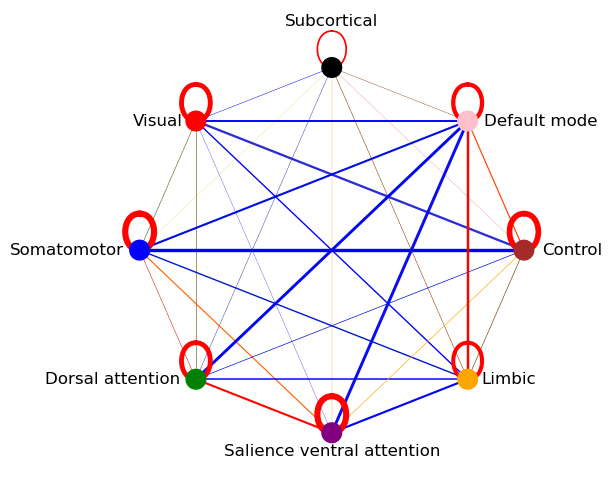

In [ ]:
params = np.load('../data/results/116_results/params/Complex_ACG_rank25_K1_params.npy', allow_pickle=True).item()
Z = get_Z(params,sort=False,idx=0,model='Complex_ACG')
Z_yeo = avg_matrix_in_networks(Z, network_indices)
fig=plot_graph_yeo(np.angle(Z_yeo),np.abs(Z_yeo))

In [ ]:
# params = np.load('../data/results/116_results/params/Complex_ACG_rank9_K1_params.npy', allow_pickle=True).item()
# Z = get_Z(params,sort=False,idx=0,model='Complex_ACG')
# plot_graph_yeo(np.angle(Z),np.abs(Z))

## K4 rank 10 complex ACG solution

In [ ]:
params = np.load('../data/results/116_results/params/modelorder_realdata_Complex_ACG_K=4_rank=10_inner0.npy', allow_pickle=True).item()
Zs = []
Zs_yeo = []
for i in range(params['M'].shape[0]):
    Zs.append(get_Z(params,sort=True,idx=i,model='Complex_ACG'))
    Z2 = get_Z(params,sort=False,idx=i,model='ACG')
    Z_yeo = avg_matrix_in_networks(Z2, network_indices)
    Zs_yeo.append(Z_yeo)
    # plotting.plot_connectome(adjacency_matrix=np.real(Z),node_coords=SchaeferTian116_coords[network_indices_concat,:],edge_threshold='99%',display_mode='lzr',node_size=10)

In [ ]:
for i in range(len(Zs)):
    plot_matrix(np.real(Zs[i]), 'Complex ACG K=4, cluster '+str(i+1)+', real',clim=(-0.5,0.5))
    plot_matrix(np.imag(Zs[i]), 'Complex ACG K=4, cluster '+str(i+1)+', imaginary',clim=(-0.5,0.5))
    plot_matrix(np.abs(Zs[i]), 'Complex ACG K=4, cluster '+str(i+1)+', magnitude',cmap=cmap_bwr2,clim=(0,0.5))
    plot_matrix(np.angle(Zs[i]), 'Complex ACG K=4, cluster '+str(i+1)+', angle',cmap=cyclic_cmap,clim=(-np.pi,np.pi))

In [ ]:
# fig,axs = plt.subplots(4,4,figsize=(8,8),layout='constrained')
# for i in range(4):
#     img1 = mpimg.imread('figs/Complex ACG, cluster '+str(i+1)+', real.png')
#     img2 = mpimg.imread('figs/Complex ACG, cluster '+str(i+1)+', imaginary.png')
#     img3 = mpimg.imread('figs/Complex ACG, cluster '+str(i+1)+', magnitude.png')
#     img4 = mpimg.imread('figs/Complex ACG, cluster '+str(i+1)+', angle.png')
#     axs[i,0].imshow(img1)
#     axs[i,0].axis('off')
#     axs[i,1].imshow(img2)
#     axs[i,1].axis('off')
#     axs[i,2].imshow(img3)
#     axs[i,2].axis('off')
#     axs[i,3].imshow(img4)
#     axs[i,3].axis('off')
# fig.savefig('figs/CACG_rank25_K4.png',dpi=600,bbox_inches='tight')

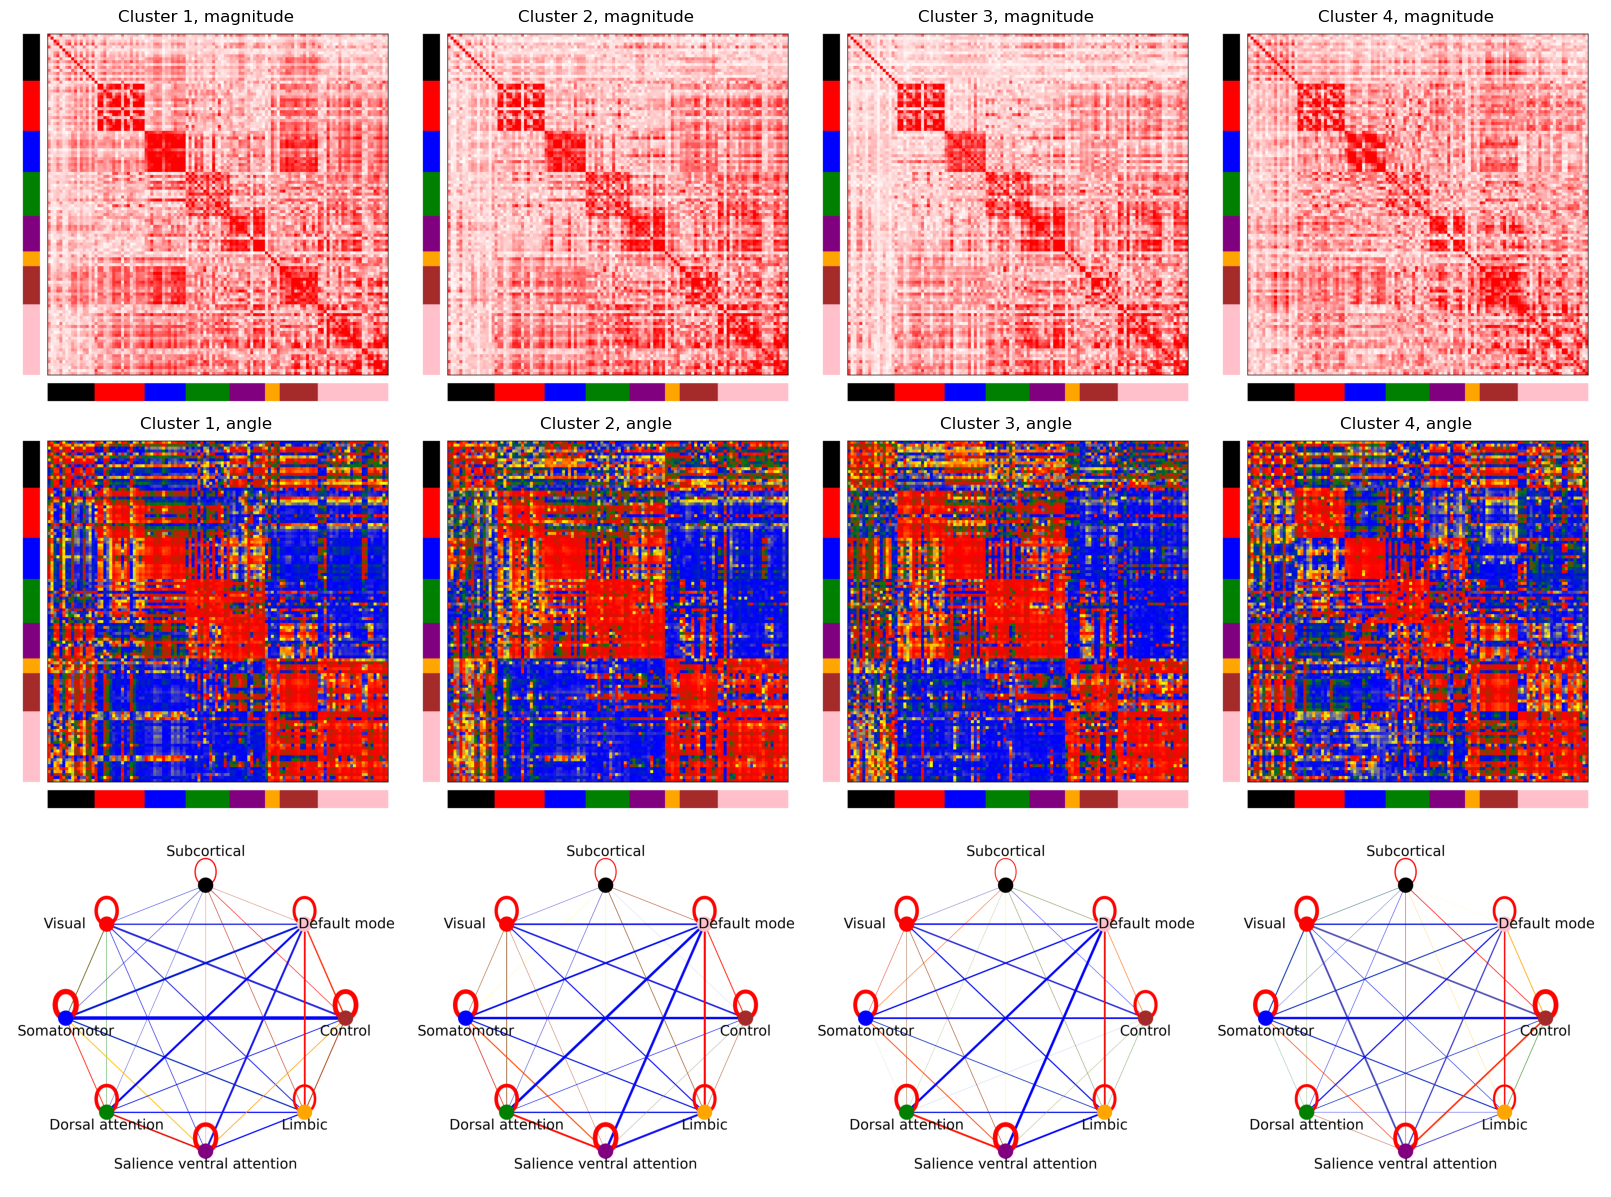

In [ ]:
fig,axs = plt.subplots(3,len(Zs),figsize=(4*len(Zs),12),layout='constrained')
for i in range(len(Zs)):
    img3 = mpimg.imread('figs/Complex ACG K=4, cluster '+str(i+1)+', magnitude.png')
    img4 = mpimg.imread('figs/Complex ACG K=4, cluster '+str(i+1)+', angle.png')
    axs[0,i].imshow(img3)
    axs[0,i].axis('off')
    axs[0,i].set_title('Cluster '+str(i+1)+', magnitude')
    axs[1,i].imshow(img4)
    axs[1,i].axis('off')
    axs[1,i].set_title('Cluster '+str(i+1)+', angle')
    fig2=plot_graph_yeo(np.angle(Zs_yeo[i]),np.abs(Zs_yeo[i]))
    fig2.savefig('figs/Complex ACG K=4, cluster '+str(i+1)+', graph.png',dpi=300,bbox_inches='tight')
    plt.close()
    img = mpimg.imread('figs/Complex ACG K=4, cluster '+str(i+1)+', graph.png')
    axs[2,i].imshow(img)
    axs[2,i].axis('off')
fig.savefig('figs/CACG_rank25_K4_v2.png',dpi=300,bbox_inches='tight')

In [ ]:
params['pi']

array([0.63488656, 0.36511344])

In [ ]:
params = np.load('../data/results/116_results/params/modelorder_realdata_Complex_ACG_K=2_rank=25_inner0.npy', allow_pickle=True).item()
Zs = []
Zs_yeo = []
for i in range(params['M'].shape[0]):
    Zs.append(get_Z(params,sort=True,idx=i,model='Complex_ACG'))
    Z2 = get_Z(params,sort=False,idx=i,model='ACG')
    Z_yeo = avg_matrix_in_networks(Z2, network_indices)
    Zs_yeo.append(Z_yeo)
    # plotting.plot_connectome(adjacency_matrix=np.real(Z),node_coords=SchaeferTian116_coords[network_indices_concat,:],edge_threshold='99%',display_mode='lzr',node_size=10)

for i in range(len(Zs)):
    plot_matrix(np.real(Zs[i]), 'Complex ACG K=2, cluster '+str(i+1)+', real',clim=(-0.5,0.5))
    plot_matrix(np.imag(Zs[i]), 'Complex ACG K=2, cluster '+str(i+1)+', imaginary',clim=(-0.5,0.5))
    plot_matrix(np.abs(Zs[i]), 'Complex ACG K=2, cluster '+str(i+1)+', magnitude',cmap=cmap_bwr2,clim=(0,0.5))
    plot_matrix(np.angle(Zs[i]), 'Complex ACG K=2, cluster '+str(i+1)+', angle',cmap=cyclic_cmap,clim=(-np.pi,np.pi))

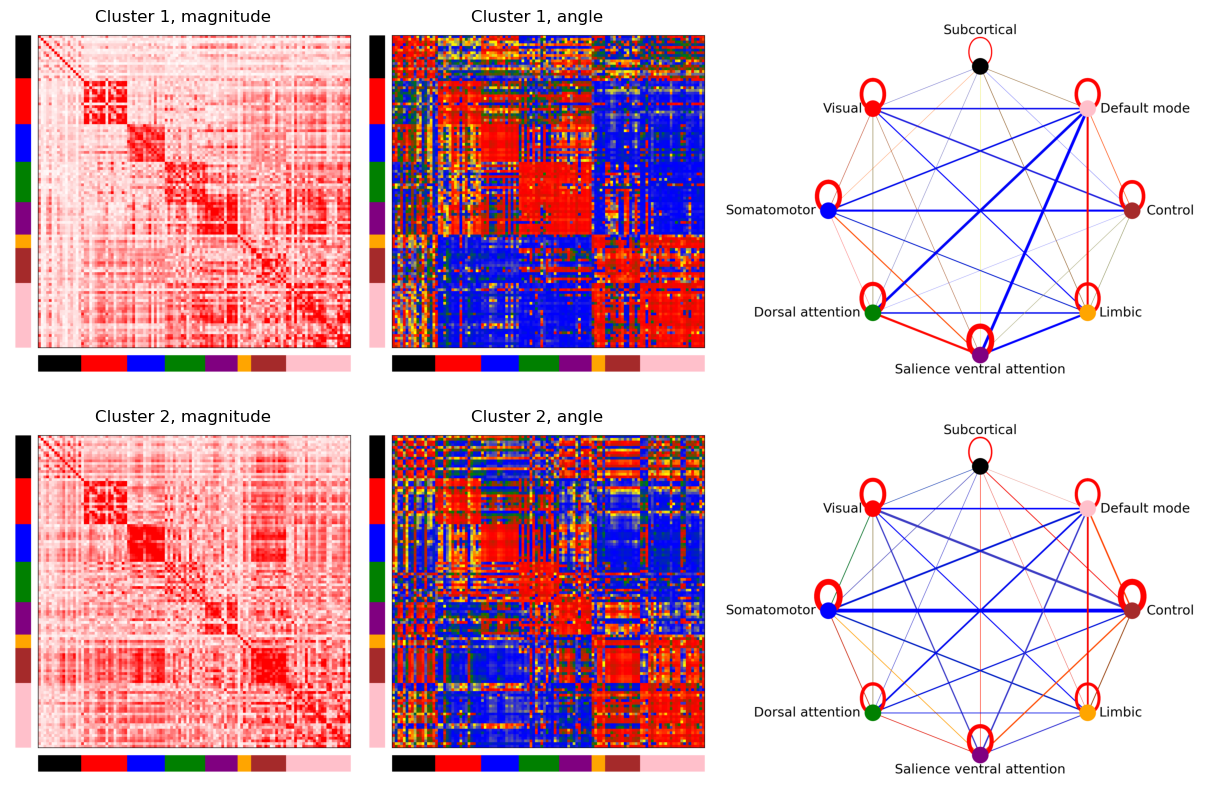

In [ ]:
fig,axs = plt.subplots(len(Zs),3,figsize=(12,4*len(Zs)),layout='constrained',width_ratios=[1,1,1.4])
for i in range(len(Zs)):
    img3 = mpimg.imread('figs/Complex ACG K=2, cluster '+str(i+1)+', magnitude.png')
    img4 = mpimg.imread('figs/Complex ACG K=2, cluster '+str(i+1)+', angle.png')
    axs[i,0].imshow(img3)
    axs[i,0].axis('off')
    axs[i,0].set_title('Cluster '+str(i+1)+', magnitude')
    axs[i,1].imshow(img4)
    axs[i,1].axis('off')
    axs[i,1].set_title('Cluster '+str(i+1)+', angle')
    fig2=plot_graph_yeo(np.angle(Zs_yeo[i]),np.abs(Zs_yeo[i]))
    fig2.savefig('figs/Complex ACG K=2, cluster '+str(i+1)+', graph.png',dpi=300,bbox_inches='tight')
    plt.close()
    img = mpimg.imread('figs/Complex ACG K=2, cluster '+str(i+1)+', graph.png')
    axs[i,2].imshow(img)
    axs[i,2].axis('off')
fig.savefig('figs/CACG_rank25_K2_v2.png',dpi=300,bbox_inches='tight')

In [ ]:
params['pi']

array([0.63488656, 0.36511344])

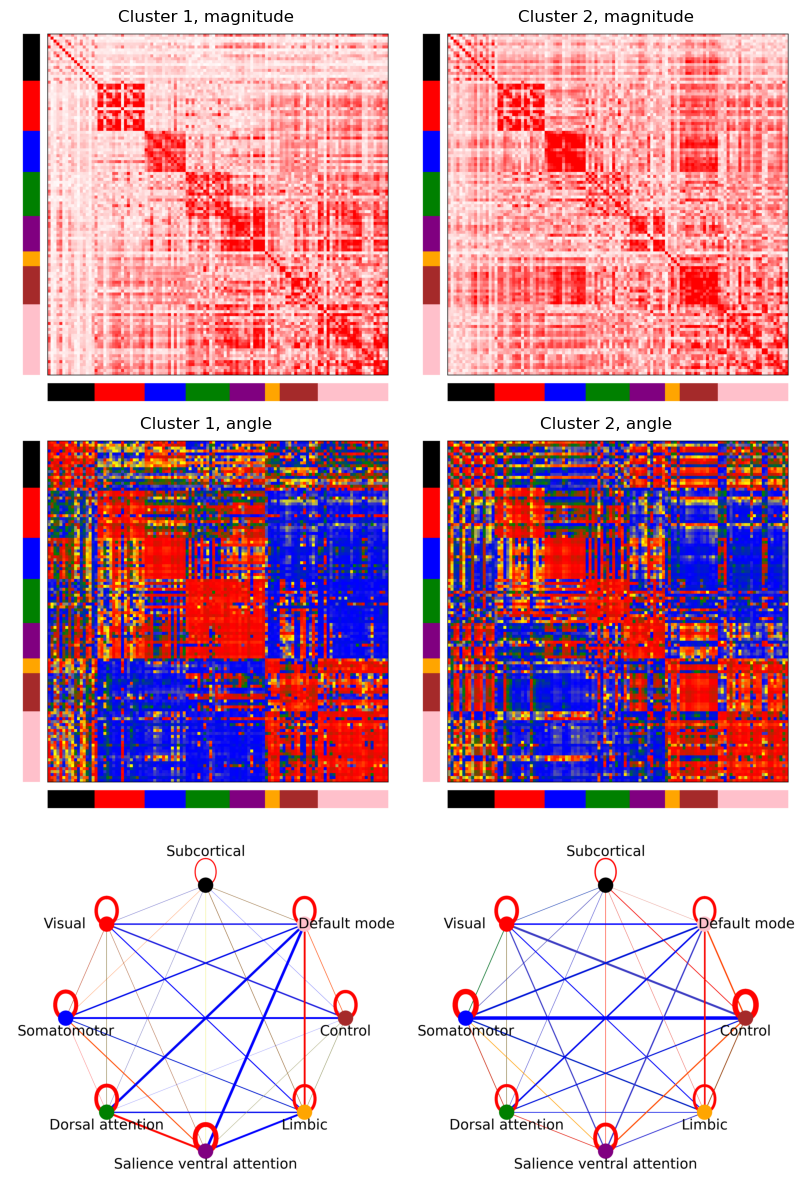

In [ ]:
# fig,axs = plt.subplots(3,len(Zs),figsize=(4*len(Zs),12),layout='constrained')
# for i in range(len(Zs)):
#     img3 = mpimg.imread('figs/Complex ACG K=2, cluster '+str(i+1)+', magnitude.png')
#     img4 = mpimg.imread('figs/Complex ACG K=2, cluster '+str(i+1)+', angle.png')
#     axs[0,i].imshow(img3)
#     axs[0,i].axis('off')
#     axs[0,i].set_title('Cluster '+str(i+1)+', magnitude')
#     axs[1,i].imshow(img4)
#     axs[1,i].axis('off')
#     axs[1,i].set_title('Cluster '+str(i+1)+', angle')
#     fig2=plot_graph_yeo(np.angle(Zs_yeo[i]),np.abs(Zs_yeo[i]))
#     fig2.savefig('figs/Complex ACG K=2, cluster '+str(i+1)+', graph.png',dpi=300,bbox_inches='tight')
#     plt.close()
#     img = mpimg.imread('figs/Complex ACG K=2, cluster '+str(i+1)+', graph.png')
#     axs[2,i].imshow(img)
#     axs[2,i].axis('off')
# fig.savefig('figs/CACG_rank25_K2_v2.png',dpi=300,bbox_inches='tight')